# Context of the problem

Cintas is a company that delivers clean uniforms to customers around the city.  While GPS can help navigate routes in real-time, route planning is done in advance based on sequencing stops based on geographical considerations. In fact, after speaking with a representative, I found that they plan routes entirely on zipcodes. The zipcode of a series of stops is not always the greatest predictor of what will complete the series of stops in the least amount of time. Can we predict traffic issues before they occur so that we may avoid them?

We will explore the Real-Time Traffic Incident Reports from Austin's Open Data Portal.
(https://data.austintexas.gov/Transportation-and-Mobility/Real-Time-Traffic-Incident-Reports/dx9v-zd7x)

# Step Taken

1. Latitude and Longitude now both float data types

2. Null values removed with little impact on number of rows

3. Traffic Report ID, Status columns removed


# Import necessary libraries

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [113]:
df = pd.read_csv('/Users/tshields/Documents/GitHub/Real-Time_Traffic_Incident_Reports/Data/traffic_data_cleaned.csv', index_col=0, parse_dates=['published_date', 'status_date'])
df.head()

,published_date,issue_reported,Location,Latitude,Longitude,Address,status_date
0,2018-06-13 06:35:59+00:00,Crash Service,"(30.283797,-97.741906)",30.283797,-97.741906,W 21ST ST & GUADALUPE ST,2018-06-13 09:00:03+00:00
1,2018-06-13 10:15:36+00:00,Traffic Hazard,"(30.339593,-97.700963)",30.339593,-97.700963,400-717 E ANDERSON LN EB,2018-06-13 11:20:03+00:00
2,2020-04-17 21:25:03+00:00,Crash Urgent,"(30.329455,-97.638105)",30.329455,-97.638105,E US 290 HWY SVRD EB & EASTERN HEIGHTS BLVD,2020-04-17 21:55:03+00:00
3,2020-04-17 21:40:52+00:00,Traffic Hazard,"(30.202806,-97.760701)",30.202806,-97.760701,5300-blk S Ih 35 Sb,2020-04-17 21:55:03+00:00
4,2020-04-17 21:00:55+00:00,Crash Urgent,"(30.184265,-97.687339)",30.184265,-97.687339,4500-4720 S Us 183 Hwy Sb,2020-04-17 23:30:04+00:00


In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 249061 entries, 0 to 249649
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   published_date  249061 non-null  datetime64[ns, UTC]
 1   issue_reported  249061 non-null  object             
 2   Location        249061 non-null  object             
 3   Latitude        249061 non-null  float64            
 4   Longitude       249061 non-null  float64            
 5   Address         249061 non-null  object             
 6   status_date     249061 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](2), float64(2), object(3)
memory usage: 15.2+ MB


# Statistical Inference

Using common techniques to explore the data further. Some questions to consider here: How many instances of an issue should there be before it can be taken seriously? Are there any coordinates that are out of bounds for the city? What is the average resolution time for solving an issue?


## Visualizing Latitude and Longitude

Are there any coordinates that are out of bounds for the city?

Text(0.5, 1.0, 'Cooridnates of Instances')

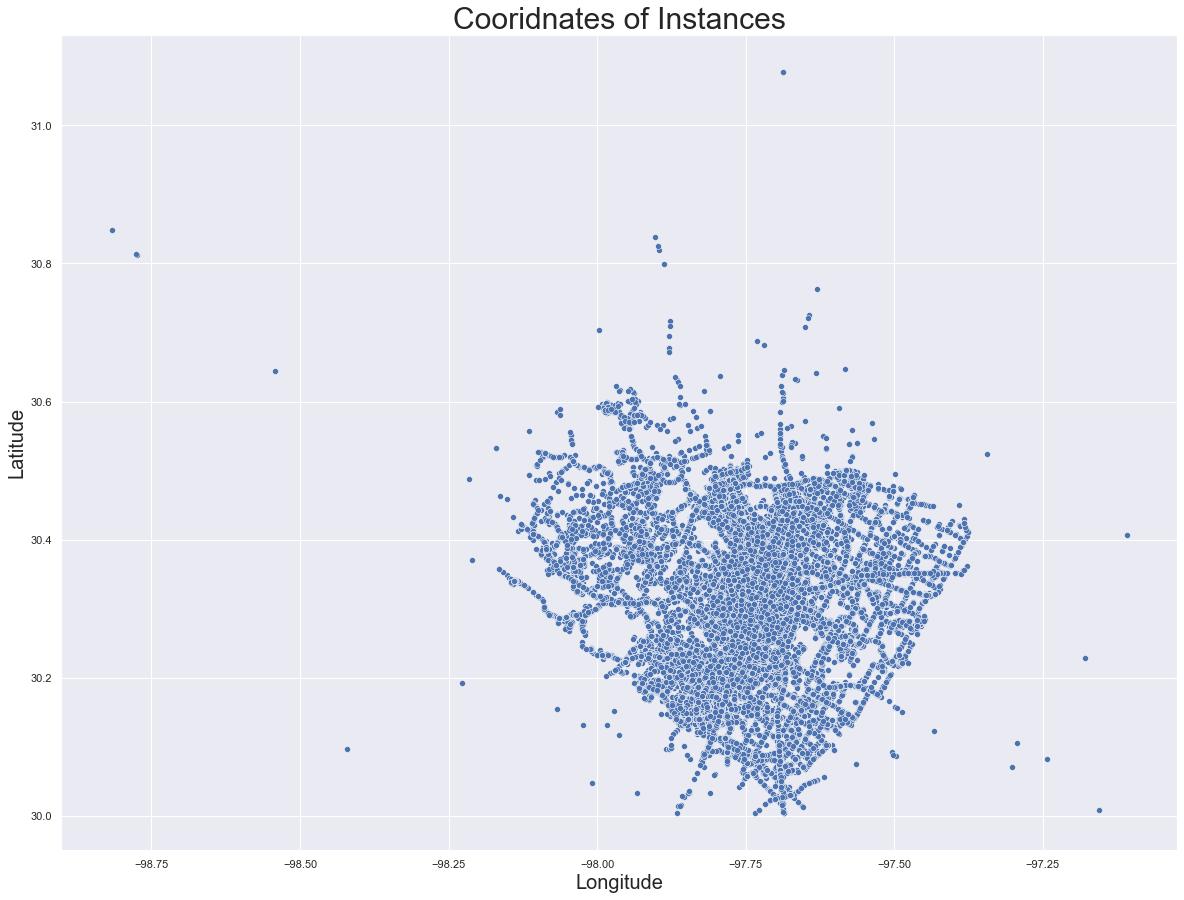

In [115]:
sns.scatterplot(x='Longitude',y='Latitude', data=df)
sns.set(rc={'figure.figsize':(25,20)})
plt.xlabel('Longitude',fontsize = 20)
plt.ylabel('Latitude',fontsize = 20)
plt.title('Cooridnates of Instances', fontsize=30)

There do appear to be incidents that are outside the city. City limits are always being redrawn but some of these look way out of bounds. Keeping that in mind there are some observables lines we can safely say are out of bounds and we will not risk losing many rows. We will then be able to visualize the incident ocurrances better. It makes sense to use the 4x4 blocks that make up the vast majority of the instances.
North = 30.8, West = -98.25, South = 30.0, East = -97.25

In [116]:
df = df[((df.Latitude >30) & (df.Latitude < 30.8))]
df= df[((df['Longitude'] < -97.25) &(df['Longitude'] > -98.25))]

Text(0.5, 1.0, 'Cooridnates of Instances')

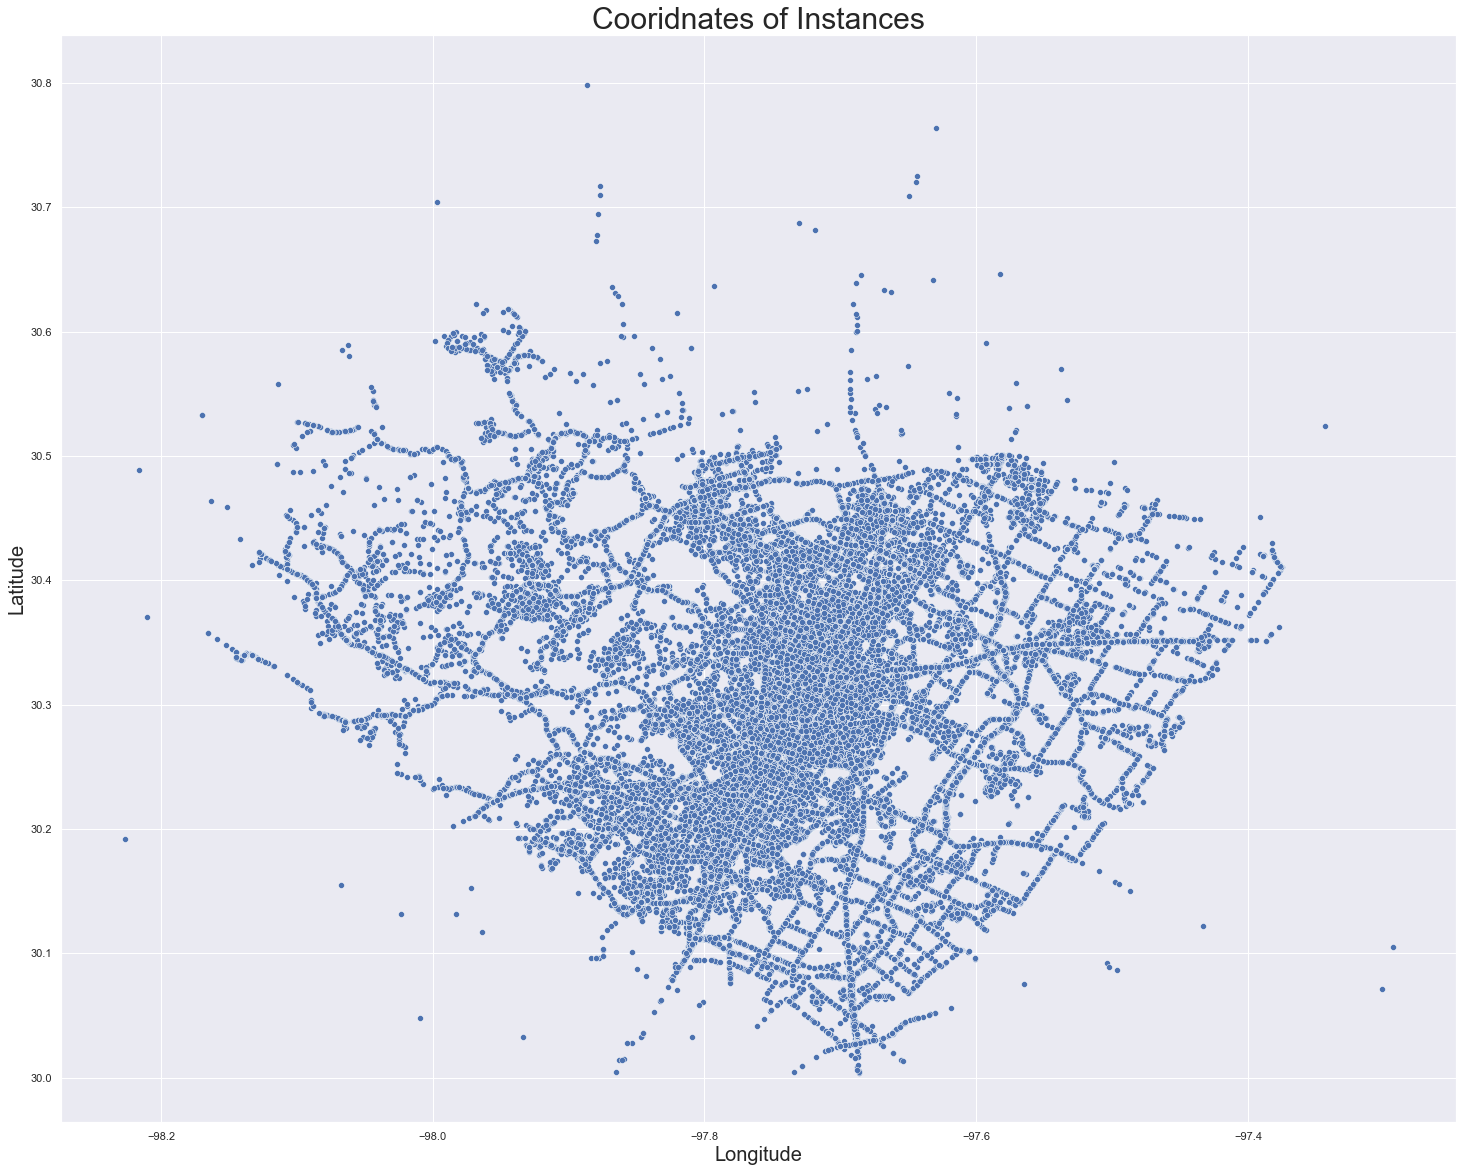

In [117]:
sns.scatterplot(x='Longitude',y='Latitude', data=df)
sns.set(rc={'figure.figsize':(25,20)})
plt.xlabel('Longitude',fontsize = 20)
plt.ylabel('Latitude',fontsize = 20)
plt.title('Cooridnates of Instances', fontsize=30)

This makes a more accurate map of the city as well as providing more detail in terms of visualization. 

# Examining Issue Timespan

Subtracting the published date from the status date will let us see how long these issues take to resolve. This will be useful in helping us understand which issues take the most time to resolve. The date and time are listed together, which may come in handy when classifying the severity of issues, but the date and time values will have to be seperated when we try to decipher seasonal and time of day data.


In [118]:
issue_time = df['status_date'] - df['published_date']
issue_time.abs()

0        0 days 02:24:04
1        0 days 01:04:27
2        0 days 00:30:00
3        0 days 00:14:11
4        0 days 02:29:09
               ...      
249645   0 days 00:05:52
249646   0 days 00:04:50
249647   0 days 00:04:43
249648   0 days 00:05:32
249649   0 days 00:04:05
Length: 249047, dtype: timedelta64[ns]


This data is useful enough to justify its own column. It can replace the 'status_date' column, as it's only purpose is to inform the timespan calculation.

In [119]:
df['issue_timespan'] = issue_time
df.drop(['status_date'], axis=1, inplace=True)
df.head()

,published_date,issue_reported,Location,Latitude,Longitude,Address,issue_timespan
0,2018-06-13 06:35:59+00:00,Crash Service,"(30.283797,-97.741906)",30.283797,-97.741906,W 21ST ST & GUADALUPE ST,0 days 02:24:04
1,2018-06-13 10:15:36+00:00,Traffic Hazard,"(30.339593,-97.700963)",30.339593,-97.700963,400-717 E ANDERSON LN EB,0 days 01:04:27
2,2020-04-17 21:25:03+00:00,Crash Urgent,"(30.329455,-97.638105)",30.329455,-97.638105,E US 290 HWY SVRD EB & EASTERN HEIGHTS BLVD,0 days 00:30:00
3,2020-04-17 21:40:52+00:00,Traffic Hazard,"(30.202806,-97.760701)",30.202806,-97.760701,5300-blk S Ih 35 Sb,0 days 00:14:11
4,2020-04-17 21:00:55+00:00,Crash Urgent,"(30.184265,-97.687339)",30.184265,-97.687339,4500-4720 S Us 183 Hwy Sb,0 days 02:29:09


In [120]:
df.issue_timespan.describe()

count                        249047
mean      3 days 04:56:04.384967496
std      44 days 19:16:38.821648022
min           -17577 days +05:40:00
25%                 0 days 00:21:00
50%                 0 days 00:42:23
75%                 0 days 01:25:01
max               233 days 08:49:00
Name: issue_timespan, dtype: object

A lot jumps out here. The minimum resolution time is a negative number which is impossible. The maximum number is over 2/3 of a year. The mean is unreasonable as the average issue cannot take over 3 days to resolve. There must be some bad values skewing our numbers. 

# Converting 'issue_timespan' from datetime object to a number

Using the current datatype for issue_timespan make no sense and it makes it much harder to come to conclusions about the variable. 

In [121]:
sec = df.issue_timespan.apply(lambda x: x.total_seconds())
df['issue_timespan'] = sec/60
df.head()

,published_date,issue_reported,Location,Latitude,Longitude,Address,issue_timespan
0,2018-06-13 06:35:59+00:00,Crash Service,"(30.283797,-97.741906)",30.283797,-97.741906,W 21ST ST & GUADALUPE ST,144.066667
1,2018-06-13 10:15:36+00:00,Traffic Hazard,"(30.339593,-97.700963)",30.339593,-97.700963,400-717 E ANDERSON LN EB,64.450000
2,2020-04-17 21:25:03+00:00,Crash Urgent,"(30.329455,-97.638105)",30.329455,-97.638105,E US 290 HWY SVRD EB & EASTERN HEIGHTS BLVD,30.000000
3,2020-04-17 21:40:52+00:00,Traffic Hazard,"(30.202806,-97.760701)",30.202806,-97.760701,5300-blk S Ih 35 Sb,14.183333
4,2020-04-17 21:00:55+00:00,Crash Urgent,"(30.184265,-97.687339)",30.184265,-97.687339,4500-4720 S Us 183 Hwy Sb,149.150000


In [122]:
df.issue_timespan.min()

-25310540.0

Time can't go backward so I'm comfortably deleting all negative values using the .abs() function

In [123]:
df['issue_timespan'] = df['issue_timespan'].abs()

In [124]:
df.issue_timespan.min()

0.3333333333333333

In [125]:
df.shape

(249047, 7)

# How do we approach the variance of issue_timespan?

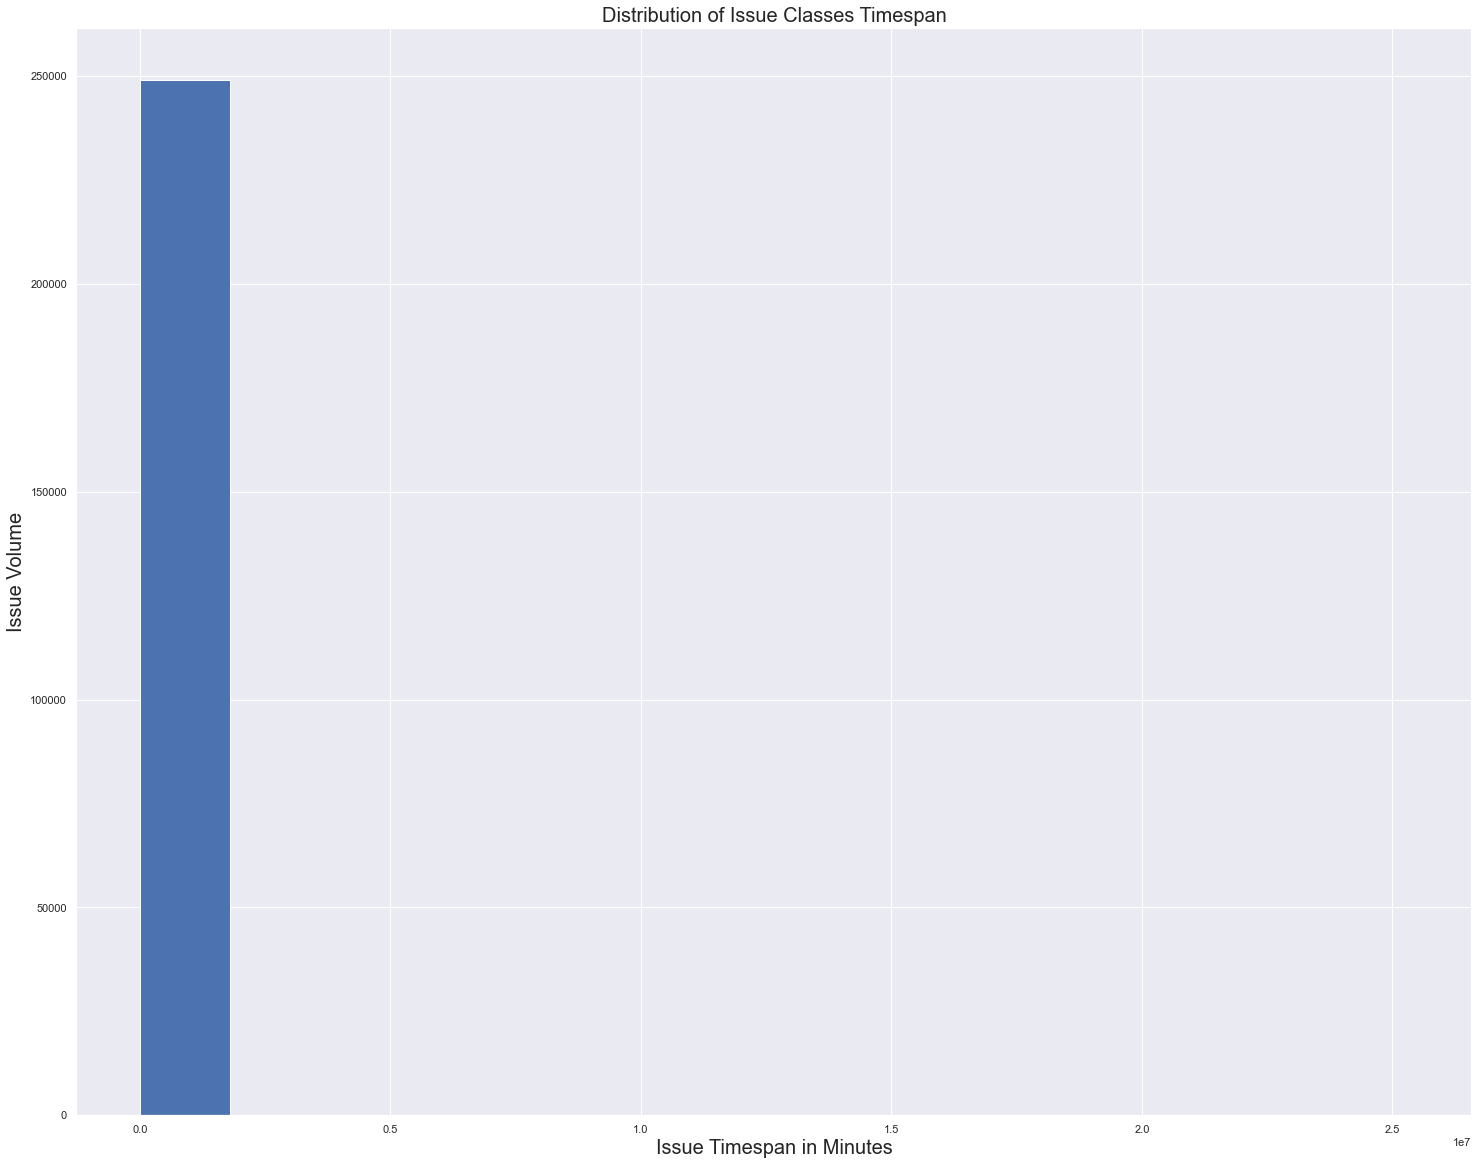

In [126]:
df.issue_timespan.hist(bins=14)
plt.xlabel('Issue Timespan in Minutes',fontsize = 20)
plt.ylabel('Issue Volume',fontsize = 20)
plt.title('Distribution of Issue Classes Timespan',fontsize = 20);

This histogram clearly show that we have outliers distorting the data.

## How much time should an incident take to clear off the road?

The max values will be much trickier to tackle. The current mean time to resolve and incident is 3 days 04:57:48 according to the summary statistics above. The max value is a whopping 233 days 08:49:00

According to this legal website https://www.denenapoints.com/long-usually-take-clear-accident-scene-houston/average the average wait time in neighboring Houston in 2011 was 33.5 minutes.

This article https://mynorthwest.com/1216262/washington-incident-response-2018/ out of Washington state claims that the average wait time in 2018 was 13 minutes. The article goes on to say there was also an uptick in accidents that took over 90 minutes to clear. They also reference "extraordinary incidents" that take an average of 12 hours to clear. However we choose to proceed with the differences in later stages, let's assume anything over 24 hours to clear is beyond extraordinary. There are 1440 minutes in a day.

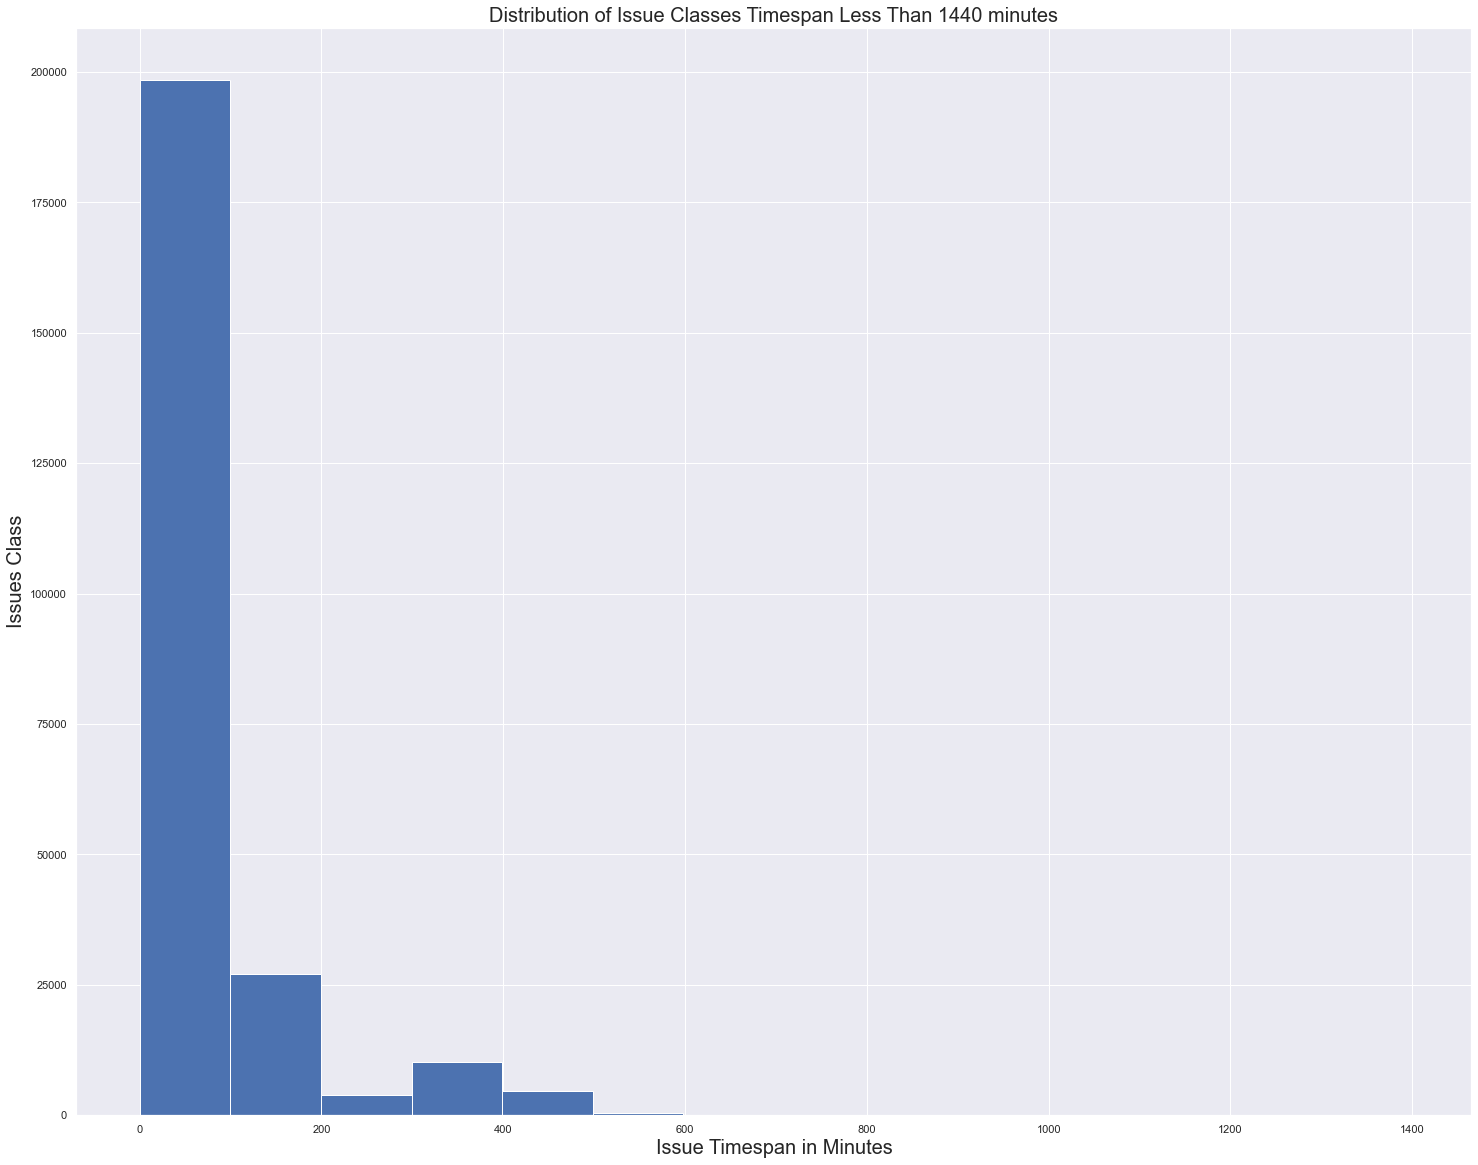

In [127]:
df.issue_timespan[df.issue_timespan < 1440].hist(bins=14)
plt.xlabel('Issue Timespan in Minutes',fontsize = 20)
plt.ylabel('Issues Class',fontsize = 20)
plt.title('Distribution of Issue Classes Timespan Less Than 1440 minutes',fontsize = 20);

The plot above shows the average timespan of a given issue in minutes of a full day, where I made my previous limit. It looks like it should be narrowed down further. It appears that there is a jump at 500 minutes.

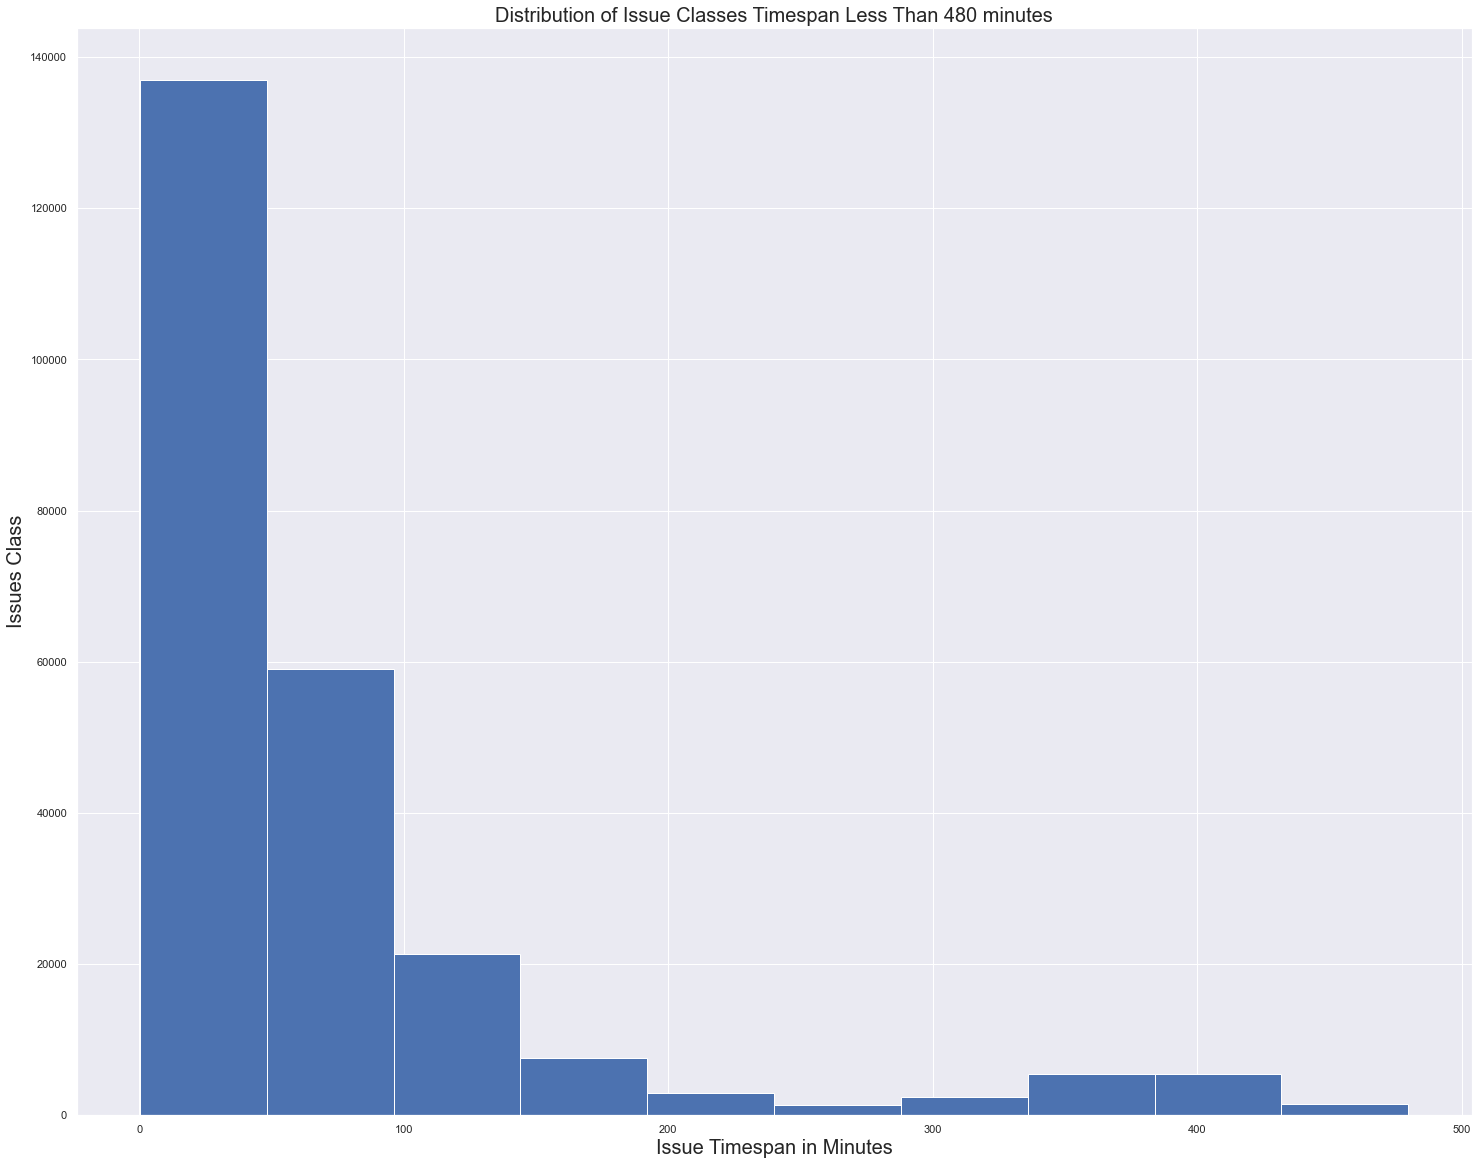

In [128]:
df.issue_timespan[df.issue_timespan < 480].hist(bins=10)
plt.xlabel('Issue Timespan in Minutes',fontsize = 20)
plt.ylabel('Issues Class',fontsize = 20)
plt.title('Distribution of Issue Classes Timespan Less Than 480 minutes',fontsize = 20);

#### We can at least see all the bins involved at 480 minutes. The vast majority of instances have a timespan of less than 200 minutes. Still, cutting that many rows would degrade our dataset significantly. Let's  bring the total to the equivalent to 8 hours.

In [129]:
df = df[df.issue_timespan <= 480]
df.issue_timespan.max()

480.0

## Volume of Unique Issues Reported

How many instances of an issue should there be before it can be taken seriously? Can category classes be combined?

In [130]:
df['issue_reported'].value_counts()
#This is labeled data for classification

Traffic Hazard                75730
Crash Urgent                  57435
Crash Service                 36373
COLLISION                     21524
TRFC HAZD/ DEBRIS             17276
zSTALLED VEHICLE               8659
LOOSE LIVESTOCK                5914
Traffic Impediment             5879
COLLISION WITH INJURY          5858
COLLISN/ LVNG SCN              4205
Stalled Vehicle                2808
COLLISION/PRIVATE PROPERTY      949
VEHICLE FIRE                    799
BLOCKED DRIV/ HWY               498
BOAT ACCIDENT                    98
AUTO/ PED                        66
TRAFFIC FATALITY                 59
FLEET ACC/ INJURY                31
ICY ROADWAY                      29
N / HZRD TRFC VIOL                6
OBSTRUCT HWY                      5
HIGH WATER                        2
FLEET ACC/ FATAL                  2
COLLISN / FTSRA                   1
Name: issue_reported, dtype: int64

There are currently 23 different categories of traffice issues. Some categories only have a few instances though.

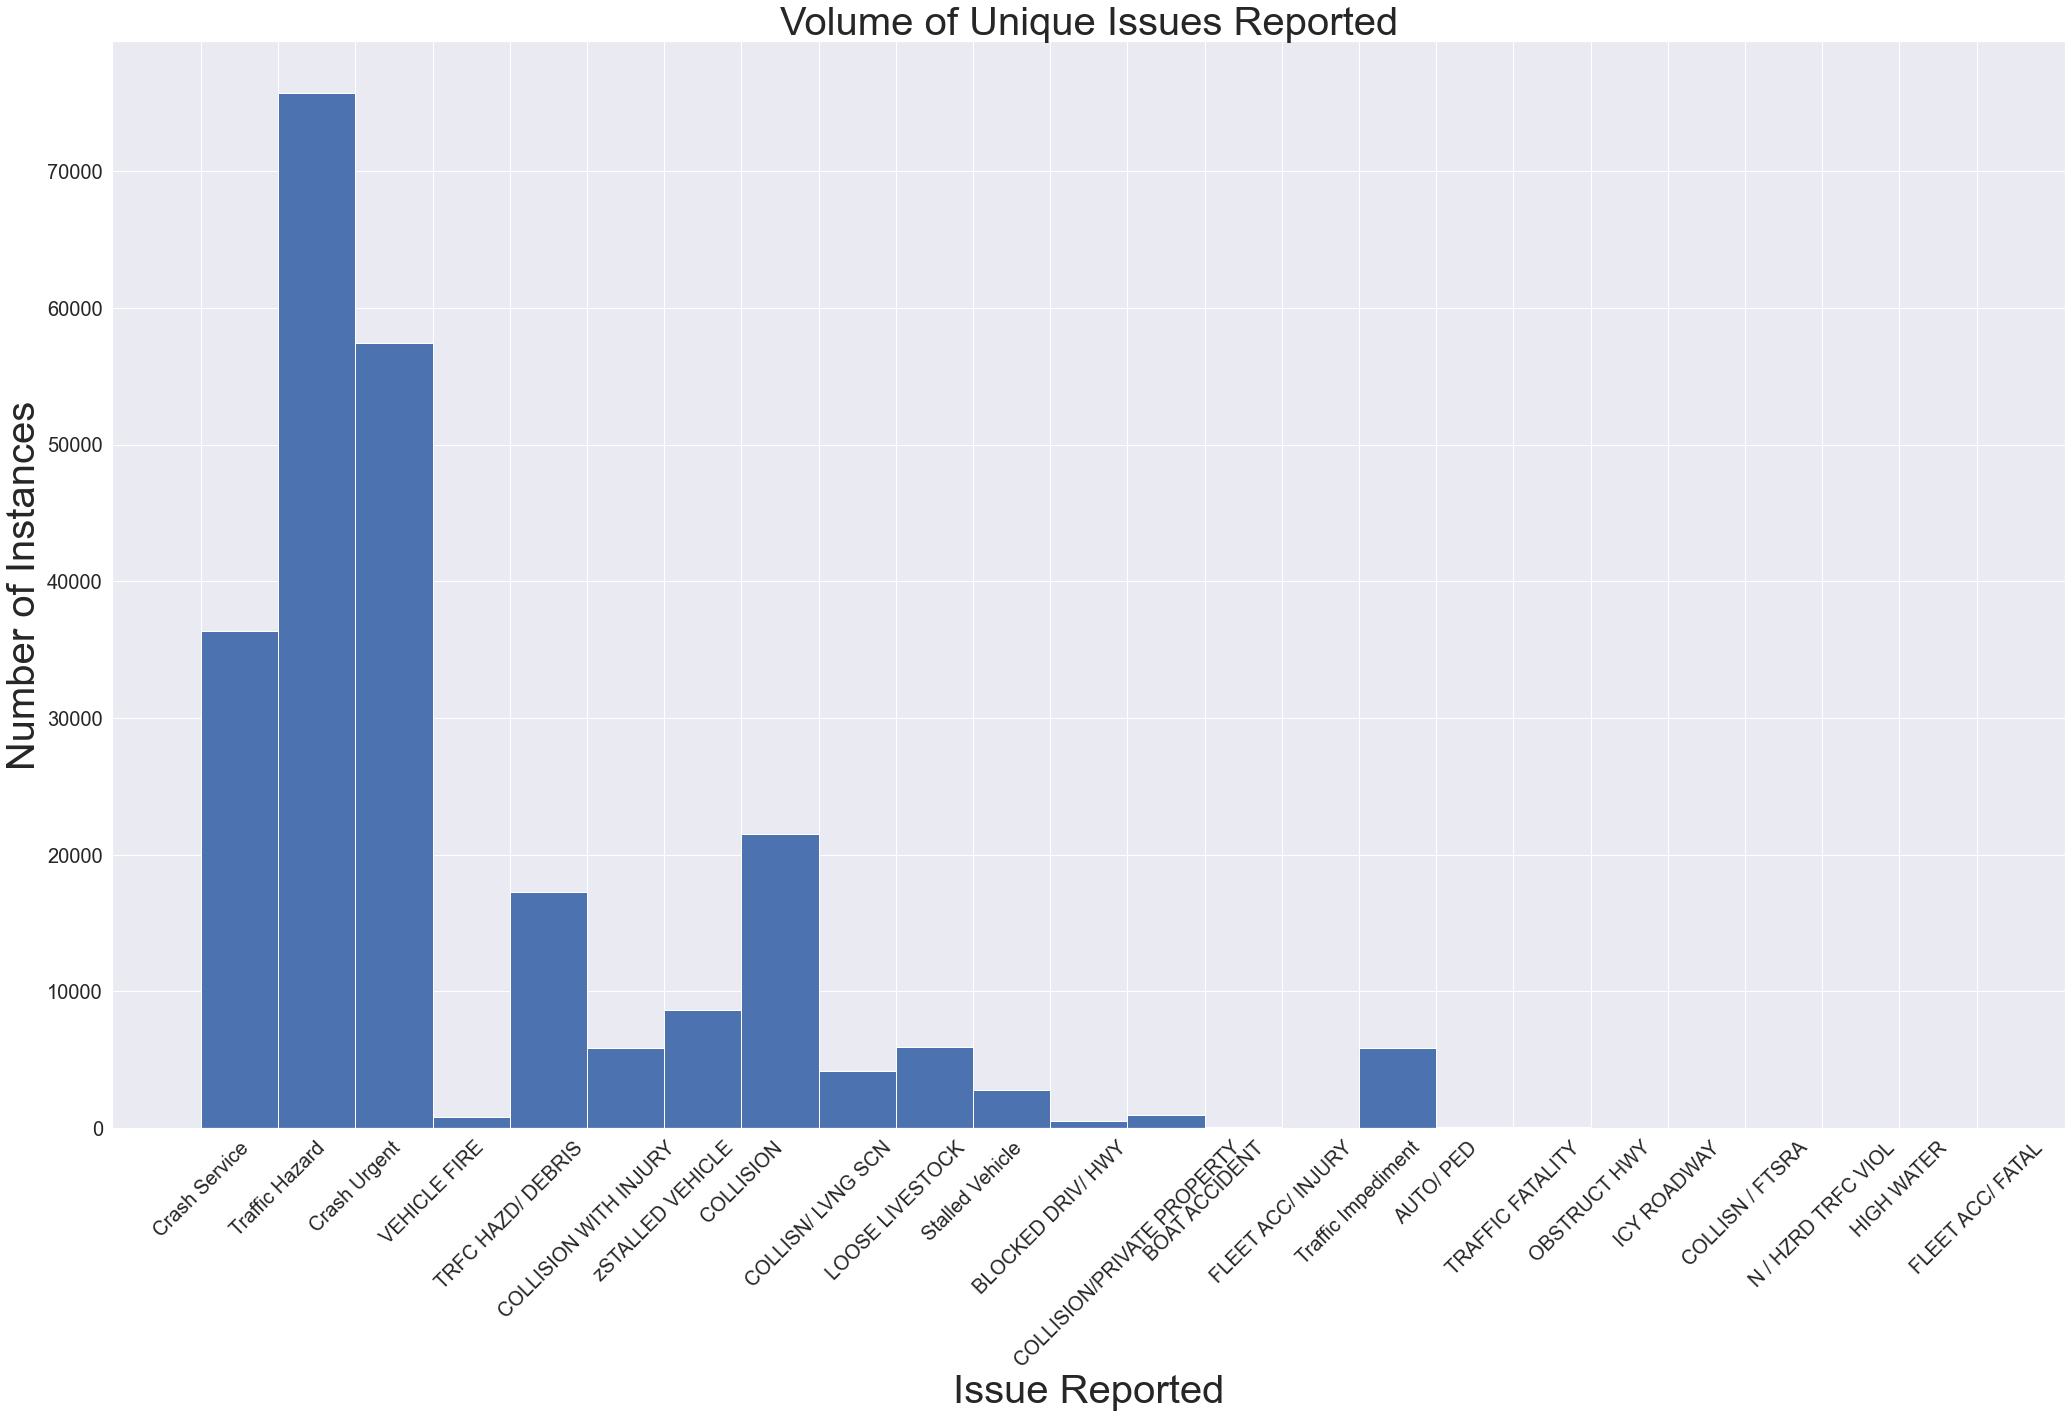

In [131]:
df.issue_reported.hist(figsize=(35,20), bins=23)
plt.xlabel('Issue Reported',fontsize = 40)
plt.ylabel('Number of Instances',fontsize = 40)
plt.xticks(fontsize = 20, rotation=45)
plt.yticks(fontsize = 20)
plt.title('Volume of Unique Issues Reported', fontsize=40)
plt.show()

There are many categories here that could be dropped due to the rarity of the occurance. Alternatively, some categories have very similar lables and could be combined (e.g. Traffic Impediment, Traffic Hazard, TRFC HAZD/DEBRIS). The first thing to do is to combine similar labels and then we can find out how many instances is too few to stand alone moving forward.

# Ensuring that combined category classes have similar values

Text(0.5, 1.0, 'Time Taken to Resolve Issue Measured in Minutes')

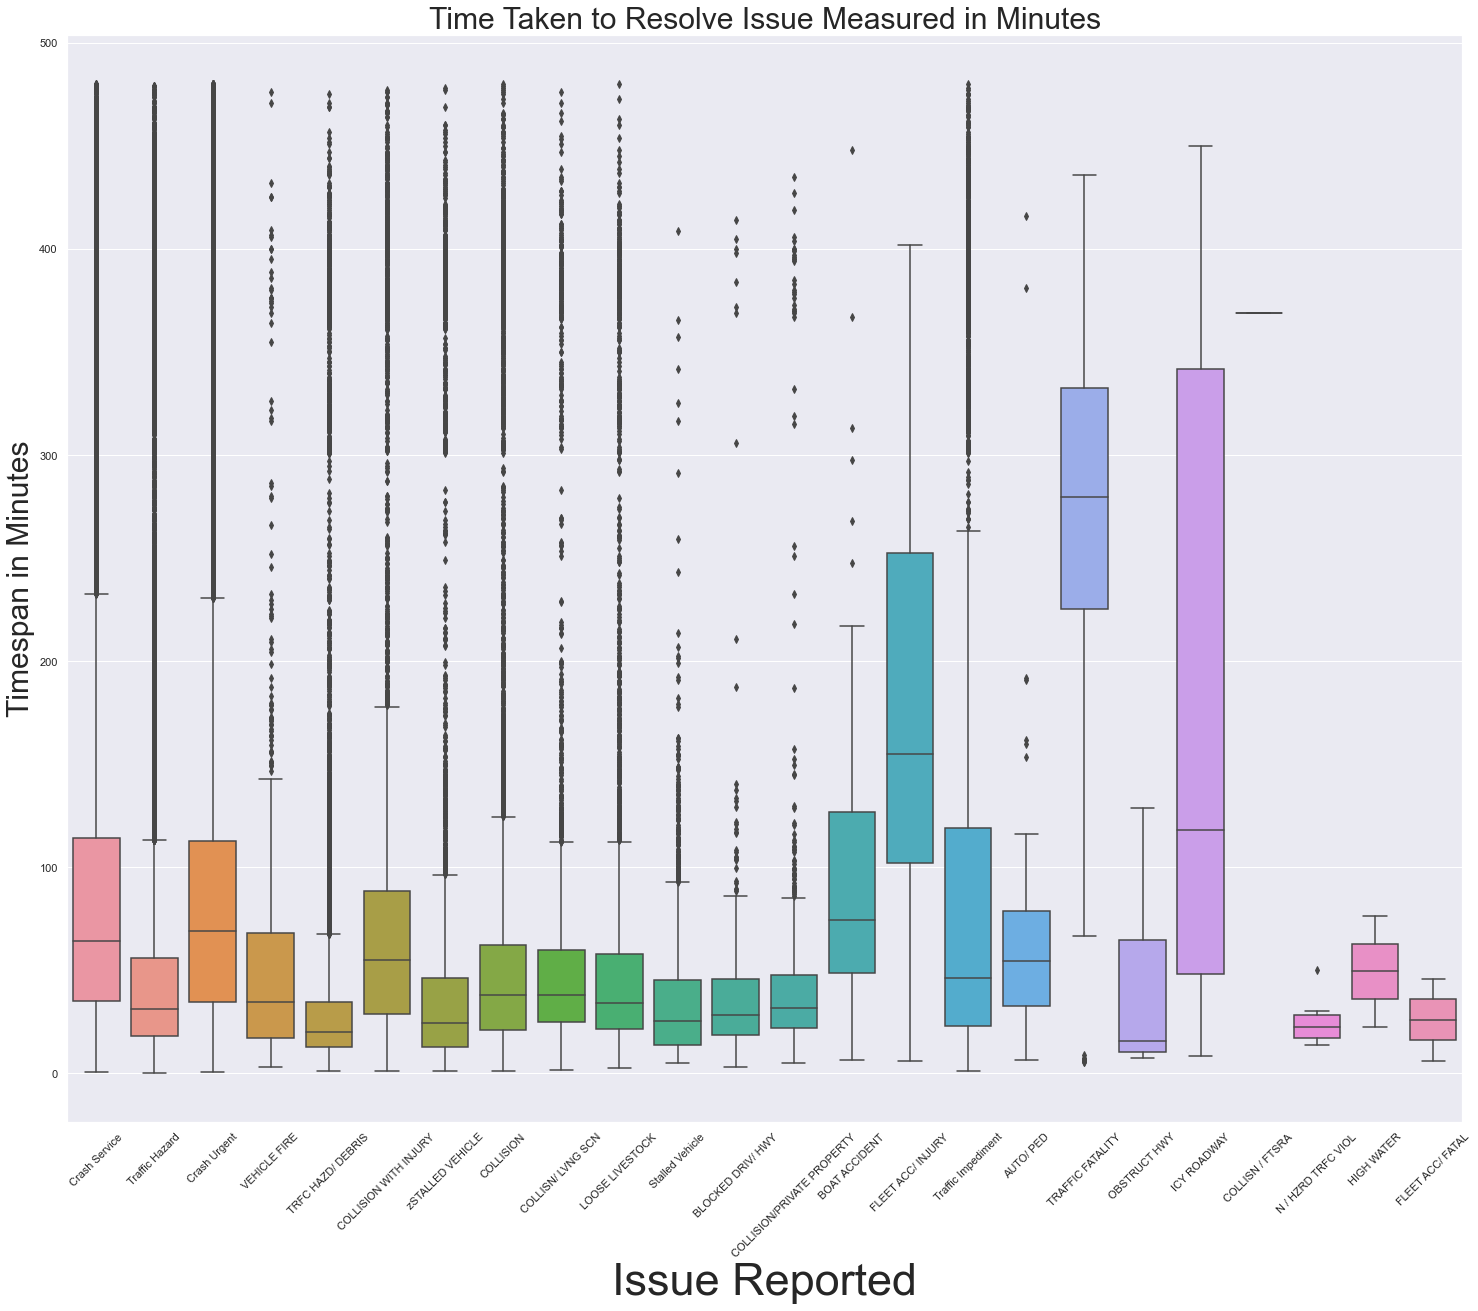

In [132]:
ax = sns.boxplot(x= 'issue_reported', y='issue_timespan', data=df)
plt.xlabel('Issue Reported' , fontsize=45)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.ylabel('Timespan in Minutes', fontsize=30)
sns.set(rc={'figure.figsize':(20,15)})
plt.title('Time Taken to Resolve Issue Measured in Minutes', fontsize=30)

In [133]:
df['issue_reported'] = df['issue_reported'].replace({'COLLISION': 'Collision'})
df['issue_reported'] = df['issue_reported'].replace({'COLLISN/ LVNG SCN': 'Collision'})
df['issue_reported'] = df['issue_reported'].replace({'COLLISION/PRIVATE PROPERTY': 'Collision'})
df['issue_reported'] = df['issue_reported'].replace({'COLLISION WITH INJURY': 'Collision'})
df['issue_reported'] = df['issue_reported'].replace({'Crash Urgent': 'Crash Service'})
df['issue_reported'] = df['issue_reported'].replace({'zSTALLED VEHICLE': 'Stalled Vehicle'})
df['issue_reported'] = df['issue_reported'].replace({'BLOCKED DRIV/ HWY': 'Stalled Vehicle'})
df['issue_reported'] = df['issue_reported'].replace({'LOOSE LIVESTOCK': 'Loose Livestock'})
df['issue_reported'] = df['issue_reported'].replace({'TRFC HAZD/ DEBRIS': 'Traffic Hazard'})
df['issue_reported'] = df['issue_reported'].replace({'N / HZRD TRFC VIOL': 'Traffic Hazard'})




df['issue_reported'].value_counts()

Crash Service         93808
Traffic Hazard        93012
Collision             32536
Stalled Vehicle       11965
Loose Livestock        5914
Traffic Impediment     5879
VEHICLE FIRE            799
BOAT ACCIDENT            98
AUTO/ PED                66
TRAFFIC FATALITY         59
FLEET ACC/ INJURY        31
ICY ROADWAY              29
OBSTRUCT HWY              5
HIGH WATER                2
FLEET ACC/ FATAL          2
COLLISN / FTSRA           1
Name: issue_reported, dtype: int64

After examining all of the category classes I have combined many that had similar descriptions and timespans. There a two classes that are weather related with very different timespans and few instances so those rows will be cut. 

In [134]:
df = df.groupby('issue_reported').filter(lambda x : len(x)>1000)
df.issue_reported.unique()

array(['Crash Service', 'Traffic Hazard', 'Collision', 'Stalled Vehicle',
       'Loose Livestock', 'Traffic Impediment'], dtype=object)

Text(0.5, 1.0, 'Time Taken to Resolve Issue Measured in Minutes')

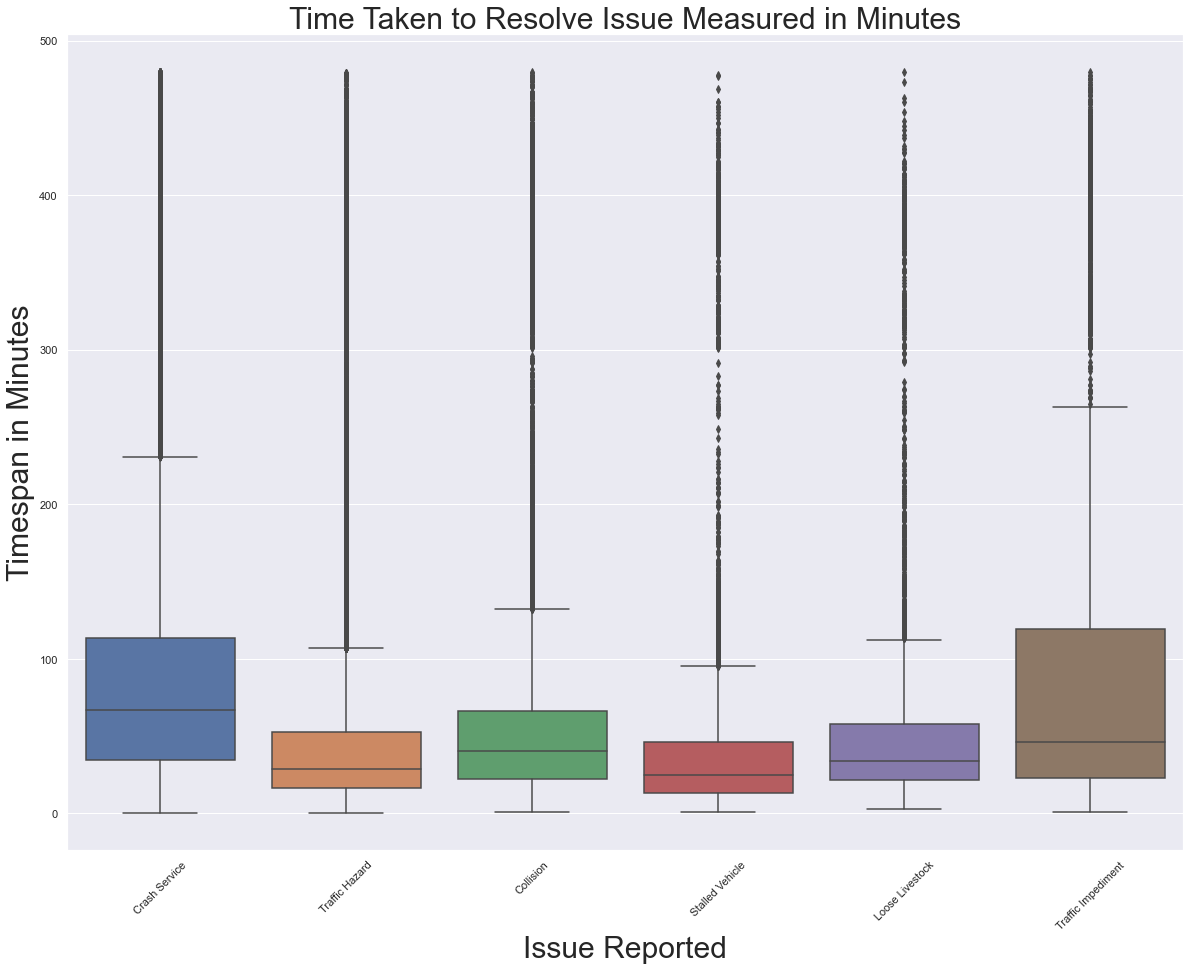

In [135]:
ax = sns.boxplot(x= 'issue_reported', y='issue_timespan', data=df)
plt.xlabel('Issue Reported' , fontsize=30)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.ylabel('Timespan in Minutes', fontsize=30)
sns.set(rc={'figure.figsize':(20,15)})
plt.title('Time Taken to Resolve Issue Measured in Minutes', fontsize=30)

In [138]:
df.issue_reported.value_counts()

Crash Service         93808
Traffic Hazard        93012
Collision             32536
Stalled Vehicle       11965
Loose Livestock        5914
Traffic Impediment     5879
Name: issue_reported, dtype: int64

This plot is much easier to read and gives us a much better idea of what issues take a long time to resolve.

Crash Service and Traffic Impediment take longest to resolve.

Stalled Vehicle and Traffic Hazard take the least amount of time to resolve.

Collision and Loose Livestock take a moderate amount of time to resolve.

In [136]:
df.shape

(243114, 7)

In [137]:
df.to_csv('traffic_eda_pt1.csv') 